In [16]:
import os
import matplotlib.pyplot as plt
import xarray as xr
from aqua import Reader
from aqua.exceptions import NoDataError
from aqua.util import load_yaml, create_folder
from aqua.logger import log_configure
from datetime import datetime

model    = "IFS"
exp      = "tco1279-orca025-cycle3"
source   = "2D_monthly_native"
regrid   = "r100"
loglevel = "WARNING"

reader = Reader(model=model, exp=exp, source=source,
                                regrid=regrid, loglevel=loglevel)
data = reader.retrieve(regrid = regrid)
lat = data.coords["lat"]
lon = data.coords["lon"]
lon1D = lon.values
lat1D = lat.values
sic = data.ci.values


2023-12-04 13:13:58 :: eccodes :: WARNING  -> ShortName tprate have multiple grib codes associated: ['260048', '172228']
2023-12-04 13:13:58 :: eccodes :: WARNING  -> AQUA will take the first so that tprate -> 260048, please set up a correct fix if this does not look right


In [6]:
reader?


Type:           Reader
String form:    <aqua.reader.reader.Reader object at 0x7fce70a384c0>
File:           ~/git/AQUA/aqua/reader/reader.py
Docstring:      General reader for NextGEMS data.
Init docstring:
Initializes the Reader class, which uses the catalog
`config/config.yaml` to identify the required data.

Args:
    model (str, optional): Model ID. Defaults to "ICON".
    exp (str, optional): Experiment ID. Defaults to "tco2559-ng5".
    source (str, optional): Source ID. Defaults to None.
    regrid (str, optional): Perform regridding to grid `regrid`, as defined in `config/regrid.yaml`. Defaults to None.
    method (str, optional): Regridding method. Defaults to "ycon".
    fix (bool, optional): Activate data fixing
    zoom (int): healpix zoom level. (Default: None)
    configdir (str, optional): Folder where the config/catalog files are located. Defaults to None.
    areas (bool, optional): Compute pixel areas if needed. Defaults to True.
    var (str or list, optional): Varia

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from   cartopy.util import add_cyclic_point
import xarray as xr
import sys
sys.path.insert(0, '..')
from colInterpolatOr import *
from matplotlib.colors import LinearSegmentedColormap


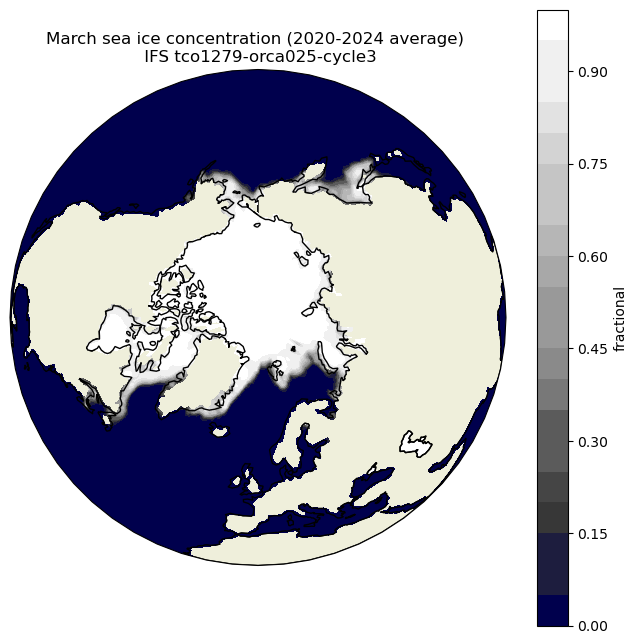

In [25]:

lon2D, lat2D = np.meshgrid(lon1D, lat1D)
dataSic = data['ci'].isel(time=0).values  # Select data for a specific time (adjust as needed)

# Create a polar stereographic projection
projection = ccrs.Stereographic(central_longitude=180.0, central_latitude=90.0)
projection = ccrs.NearsidePerspective(central_longitude=0.0, central_latitude=90.0, satellite_height=35785831, false_easting=0, false_northing=0, globe=None)


# Create color sequence for sic
#sourceColors = [[0.1, 0.45, 0.2], [0.4, 0.8, 0.2]]
sourceColors = [[0.0, 0.0, 0.3], [0.2, 0.2, 0.2], [0.3, 0.3, 0.3],[0.5, 0.5, 0.5], [0.6, 0.6, 0.6], [0.7, 0.7, 0.7], [0.8, 0.8, 0.8], [0.9, 0.9, 0.9],[1.0, 1.0, 1.0]]
#%targetColors = colInterpolatOr(sourceColors, 30, colorCode = "RGB")
#print(len(targetColors))
myCM = LinearSegmentedColormap.from_list('myCM', sourceColors, N = 15)

# Create a figure and axis with the specified projection
fig, ax = plt.subplots(subplot_kw={'projection': projection}, figsize=(8, 8))


# Add cyclic points to avoid a white Greenwich meridian
varShow, lon1DCyclic = add_cyclic_point(dataSic, coord = lon1D, axis = 1)

# Plot the field data using contourf
levels = np.arange(0.0, 1.05, 0.05)
contour = ax.contourf(lon1DCyclic, lat1D, varShow, levels = levels, transform=ccrs.PlateCarree(), cmap=myCM)


# Add coastlines and gridlines
ax.coastlines()
#ax.gridlines()
ax.add_feature(cfeature.LAND, edgecolor='k')

# Add colorbar
cbar = plt.colorbar(contour, ax=ax, orientation='vertical', pad=0.05)
cbar.set_label('fractional')

# Set title
ax.set_title('March sea ice concentration (2020-2024 average) \n IFS tco1279-orca025-cycle3')

# Show the plot
plt.show()



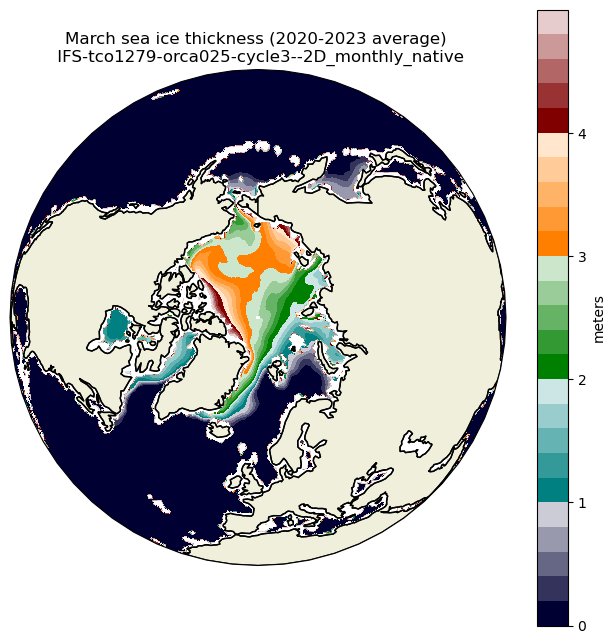

In [14]:
# Thickness maps
lon2D, lat2D = np.meshgrid(lon1D, lat1D)

month_diagnostic = 3 # Classical (non-Pythonic) convention
start_year = 2020
end_year   = 2023

monthNames = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]

maskTime = (data['time.month'] == month_diagnostic) & \
           (data['time.year'] >= start_year)        & \
           (data['time.year'] <= end_year)

dataThick = data.sithick.where(maskTime, drop=True).mean("time").values

# data['sithick'].sel(time=slice(d1, d2)).values  # Select data for a specific time (adjust as needed)

# Create a polar stereographic projection
projection = ccrs.Stereographic(central_longitude=180.0, central_latitude=90.0)
projection = ccrs.NearsidePerspective(central_longitude=0.0, central_latitude=90.0, satellite_height=35785831, false_easting=0, false_northing=0, globe=None)


# Create color sequence for sic
masterColors = [[0.0, 0.0, 0.2],[0.0, 0.8, 0.8], [0.0, 0.1, 0.0],[0.0, 0.0, 0.4],]
masterColors = [[0.0, 0.0, 0.2],[0.0, 0.5, 0.5],[0.0, 0.5, 0.0], [1.0, 0.5, 0.0], [0.5, 0.0, 0.0] ]

listCol = list()
for m in masterColors:
    alpha = 0.80
    tmp = colInterpolatOr([m, [mm + alpha * (1 - mm) for mm in m]], 5)
    listCol += tmp

myCM = LinearSegmentedColormap.from_list('myCM', listCol, N = len(listCol))

# Create a figure and axis with the specified projection
fig, ax = plt.subplots(subplot_kw={'projection': projection}, figsize=(8, 8))


# Add cyclic points to avoid a white Greenwich meridian
varShow, lon1DCyclic = add_cyclic_point(dataThick, coord = lon1D, axis = 1)

# Plot the field data using contourf
levels = np.arange(0.0, 5.05, 0.2)
levelsShow = np.arange(0.0, np.max(levels), 1.0)
contour = ax.contourf(lon1DCyclic, lat1D, varShow, levels = levels, transform=ccrs.PlateCarree(), cmap=myCM)


# Add coastlines and gridlines
ax.coastlines()
#ax.gridlines()
ax.add_feature(cfeature.LAND, edgecolor='k')

# Add colorbar
cbar = plt.colorbar(contour, ax=ax, orientation='vertical', pad=0.05)
cbar.set_label('meters')
cbar.set_ticks(levelsShow)

# Set title
ax.set_title(monthNames[month_diagnostic - 1] + ' sea ice thickness (' + str(start_year) + "-" + str(end_year) + ' average) \n ' + str(model) + "-" + str(exp) + "-" + str(source))

# Show the plot
plt.show()

